# Lab 7: Recurrent Network Atchitectures

### James O. Thomas
### Xiaoxian Jing
### Kuang Yan

1. [Data Selection](#data_selection) <br>
  1.1 [Stock Prices Example](#pure_stock) <br>
  1.2 [Stock Prices and News](#stock_and_news) <br>
2. [Preparation](#preparation) <br>
  2.1 [Class Variables](#class_varibles) <br>
  2.2 [Metrics](#metrics) <br>
  2.3 [Test-Train Split](#test_train_split) <br>
3. [Modeling](#modeling) <br>
  3.1 [Architectures](#architectures) <br>
  3.2 [Second Recurrent Chain](#second_chain) <br>
  3.3 [Evaluation](#evaluation) <br>
4. [Exceptional Work](#exceptional_work) <br>
  4.1 [Additional Analysis](#additional_analysis) <br>
  4.1 [Simple RNN](#simple_numerics) <br>
  4.2 [Visualize Word Embeddings](#visualize_embeddings) <br>
  4.3 [Novel Text](#novel_text) <br>
5. [Final Thoughts](#final_thoughts) <br>

<a id="data_selection"></a>

# Data Selection

> Select a dataset similarly to lab one:text. That is, the dataset should be text data (or a time series sequence). In terms of generalization performance, it is helpful to have a large dataset of similar sized text documents. It is fine to perform binary classification or multi-class classification. The classification can be "many-to-one" or "many-to-many" sequence classification, whichever you feel more comfortable with. 

For this lab we will be using stock prices and news. There are several ways to get historical stock prices (see below), but getting historical news headlines is somewhat harder. Therefore we will use the kaggle data set from https://www.kaggle.com/aaron7sun/stocknews. This source aggregated the news headlines from reddit (that's somewhat scary) and the stock information is from yahoo finance.

<a id="pure_stock"></a>

## Stock Prices Example

Below is an example of retrieving pure stock prices

In [149]:
# pure stock prices using pandas_datareader
import pandas_datareader.data as web
import datetime as dt

start = dt.datetime(2008, 8, 8)
end = dt.datetime.now()

# dow https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average
# S&P 500
# Nasdaq

tsla_df = web.DataReader("TSLA", 'yahoo', start, end)
msft_df = web.DataReader("MSFT", 'yahoo', start, end)
dji_df = web.DataReader('^DJI', 'yahoo', start, end) # 'yahoo', 'fred'?
gspc_df = web.DataReader('^GSPC', 'yahoo', start, end) # 'yahoo', 'fred'?

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_stock(df, title=''):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(df['High'], label='High')
    ax.plot(df['Low'], label='Low')
    ax.plot(df['Open'], label='Open')
    ax.plot(df['Close'], label='Close')
    ax.plot(df['Adj Close'], label='Adj Close')
    ax.set(title=title, ylabel='price', xlabel='date')
    plt.xticks(rotation=45)
    l = ax.legend()
    fig.show()

In [151]:
dji_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-08-08,11759.959961,11388.040039,11432.089844,11734.320312,212830000,11734.320312
2008-08-11,11867.110352,11675.530273,11729.669922,11782.349609,183190000,11782.349609
2008-08-12,11782.349609,11601.519531,11781.700195,11642.469727,173590000,11642.469727
2008-08-13,11633.780273,11453.339844,11632.809570,11532.959961,182550000,11532.959961
2008-08-14,11718.280273,11450.889648,11532.070312,11615.929688,159790000,11615.929688


C:\ProgramData\Anaconda3\envs\machine_learning_python\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


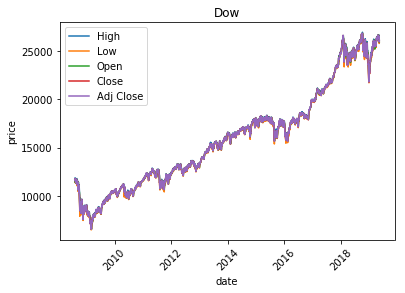

In [152]:
plot_stock(dji_df, title='Dow')

<a id="stock_and_news"></a>

## Stock Prices and News

Now we will import the stock and news prices for use in this lab.

In [ ]:
DJIA_df = pd.read_csv('DJIA_table.csv')
news_df = pd.read_csv('Combined_News_DJIA.csv')

In [ ]:
DJIA_df.reindex(index=DJIA_df.index[::-1])
DJIA_df.head()

In [ ]:
DJIA_df['Change'] = DJIA_df['Close'].diff()
DJIA_df['Change'] = DJIA_df['Change'].shift(-1)
DJIA_df.head()

In [ ]:
DJIA_df.dropna(inplace=True)
DJIA_df.isna().sum()

<a id="preparation"></a>

# Preparation

<a id="class_variables"></a>
    
## Class Variables

> __[10 points]__ Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). __Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.__ 

The data contains 6 numeric features for each day: opening stock price, high stock price, low stock price, closing stock price, volume (number of stocks), and adjusted close. The adjusted closing price is calculated by yahoo and takes into account things such as dividends paid or stock splits, as well as new stock offerings. All of these features will be normalized to floats using min/max scaling. We also use the headlines included in the data set. The words in these headlines are converted to vectors using GloVe.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# how do you normalize these? How do you not data snoop?
Data_df = DJIA_df[[col for col in list(DJIA_df) if (col != 'Change' and col != 'Date')]]
Target_df = DJIA_df['Change']

# now the normalization
min_max_scaler = MinMaxScaler()
X_data = min_max_scaler.fit_transform(Data_df.values)
Y = Target_df.values

In [ ]:
def make_datasets(X, Y, length=60):
    if len(X) != len(Y):
        print('you done messed up')
    X_data_list = []
    Y_data_list = []
    for i in range(length, len(X)):
        X_data_list.append(X[i-length:i,:])
        Y_data_list.append(Y[i])
    X_data = np.array(X_data_list)
    Y_data = np.array(Y_data_list)
    return(X_data, Y_data)

In [ ]:
X_DJIA, Y = make_datasets(X_data, Y)

In [ ]:
news_df.head()

In [ ]:
news_df.drop(columns=['Date','Label'],inplace=True)

In [ ]:
news_df['All'] = ''
for col in news_df:
    if col!='All':
        news_df['All'] += news_df[col]
news_df = news_df.astype(str)

In [ ]:
NUM_TOP_WORDS = None
MAX_ART_LEN = 50 # maximum and minimum number of words

X_news = []

#to make sure each news is MAX_ART_LEN, thus seperatable
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(news_df['All'])

for col in news_df:
    if col!='All':
        sequences = tokenizer.texts_to_sequences(news_df[col])
        X_tmp = pad_sequences(sequences, maxlen=MAX_ART_LEN,padding='pre')
        X_news += [X_tmp]


word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

In [ ]:
X_news = [news[60:-1] for news in X_news]

In [ ]:
X_final = X_news + [X_DJIA]
Idx = np.array([i for i in range(len(X_DJIA))])
Idx_train, Idx_test = train_test_split(Idx, test_size=0.1,random_state=42)
X_train = [_[Idx_train] for _ in X_final]
X_test = [_[Idx_test] for _ in X_final]
Y_train = Y[Idx_train]
Y_test = Y[Idx_test]

<a id="metrics"></a>

## Metrics

> __[10 points]__ Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a __detailed argument for why this (these) metric(s) are appropriate__ on your data. That is, why is the metric appropriate for the task (_e.g._, in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

During training of our model we will monitor the mean squared error (mse) between the predicted next day closing value and the actual next day closing value. However, we will also use the predictions from a trained model to calculate how much money we would have if we had invested it at a specific time. For this get_rich metric we will use several simplifications. We will ignore any trading fees associated with buying/selling stocks and we will also assume we will buy partial stocks. We will also assume that we can sell and buy the stocks requested immediately. 

In [412]:
y_test = [ 2.07000000e+02, -2.13896490e+01,  7.32695310e+01,  8.31699220e+01,
 -6.31894530e+01, -6.31894530e+01, -1.06629883e+02, -3.90488280e+01,
 -1.52500000e+02, -3.24316410e+01,  1.70689453e+02,  2.62998040e+01,
  1.49804690e+01, -1.38691410e+01, -1.83379883e+02,  2.68370117e+02,
  2.54150391e+02,  5.31298830e+01, -6.61035200e+00, -5.36806640e+01,
 -5.05498050e+01,  5.04480468e+02,  2.64101570e+01, -5.33007800e+00,
  1.01370117e+02,  2.13270508e+02,  6.26806640e+01,  1.15150391e+02,
 -2.15140625e+02,  2.48419922e+02, -3.36308600e+01, -9.12617190e+01,
  3.93798830e+01, -1.10240234e+02,  5.04394530e+01,  4.84492190e+01,
  1.62870118e+02,  6.65800780e+01,  5.57802730e+01, -1.06409668e+02,
 -7.67099610e+01,  9.38691400e+01, -1.03839843e+02,  1.42201172e+02,
  1.57140625e+02,  3.57011710e+01,  4.19629883e+02,  1.39879882e+02,
  1.59709961e+02,  1.71103510e+01,  8.70019600e+00,  2.11894530e+01,
  1.39939453e+02, -3.31992190e+01,  2.42120117e+02,  3.98105470e+01,
  1.21410157e+02, -1.06290039e+02, -1.64790039e+02, -1.12130859e+02,
 -1.49414000e-01, -5.24501950e+01,  2.81399903e+02, -8.81699220e+01,
  4.31601560e+01, -3.03408210e+01,  1.78840821e+02, -1.16015700e+00,
  4.07304690e+01, -5.90400390e+01,  6.79950195e+02, -2.63398440e+01,
  6.87900390e+01, -4.76894530e+01,  5.05800790e+01,  4.59785160e+01,
  2.51900390e+02,  2.76089844e+02,  7.33080078e+02,  7.76406250e+01,
  2.65870117e+02, -4.17802730e+01, -2.12298828e+02,  1.29003900e+00,
  1.41380860e+02, -4.42900390e+01,  1.98994140e+01,  3.18239257e+02,
  7.31103510e+01,  5.99394530e+01, -2.64101560e+01, -6.97998050e+01,
 -5.62207030e+01, -2.14599600e+01, -6.51191410e+01,  4.19296880e+01,
 -1.17609375e+02,  3.31339843e+02, -7.15205080e+01, -3.79440429e+02,
 -4.05898430e+01, -2.00359375e+02,  3.07197270e+01, -1.51894530e+01,
  4.16210930e+01,  8.00780000e-02, -7.23710940e+01,  3.26049804e+02,
  2.99306640e+01,  5.88798830e+01, -2.59830078e+02, -1.52290039e+02,
 -1.47469727e+02, -3.66015700e+00, -1.46750000e+02, -5.63203130e+01,
  2.37187500e+01,  3.08798830e+01, -1.38380860e+02, -1.97839844e+02,
 -7.09599610e+01, 1.04100585e+02,  4.86010742e+02,  7.35937500e+00,
  3.72402340e+01, -4.42900390e+01,  1.53490235e+02,  7.45019500e+00,
 -2.63300780e+01, -4.51406240e+01,  2.59394530e+01,  3.48220703e+02,
 -4.75498040e+01,  2.60791010e+01,  2.65419922e+02,  1.53679688e+02,
  7.79394530e+01, -1.33239258e+02, -1.97849609e+02,  5.43300780e+01,
  1.01110351e+02, -8.52500000e+01, -3.37320312e+02,  3.37940430e+02,
  1.75990235e+02, -1.33701180e+01, -1.64800782e+02, -3.95498050e+01,
 -3.27705080e+01,  1.30780273e+02,  7.46113280e+01, -1.68429687e+02,
 -9.44921800e+00,  4.11299805e+02, -8.88505860e+01,  1.86060547e+02,
 -6.28691400e+01, -4.90400390e+01,  2.52150390e+02,  6.92998050e+01,
 -1.90859374e+02, -5.89990200e+00, -1.50250000e+02, -7.50000000e-01,
  2.80009765e+02,  4.13398430e+01,  3.55957100e+00, -1.21070313e+02,
  1.90703130e+01, -3.05450195e+02, -6.22099610e+01,  1.36990234e+02,
 -8.53300790e+01,  4.27470215e+02,  1.10498050e+01,  2.05498050e+01,
 -6.87294930e+01, -9.65302730e+01,  5.88798830e+01,  4.85000000e+01,
 -7.34707040e+01, -2.39660157e+02,  2.50498050e+01,  2.47500000e+01,
  2.83007800e+00, -2.48019531e+02, -2.76953100e+00, -6.88798830e+01,
 -2.20195320e+01, -4.90595700e+01,  5.41015600e+00,  5.29003900e+00,
 -1.44319336e+02]

y_hat_test = [[ 3.48568459e+01],
       [ 8.55746918e+01],
       [ 3.64781914e+01],
       [ 4.48306618e+01],
       [ 6.57605827e-02],
       [ 1.10593767e+01],
       [ 2.97610416e+01],
       [ 6.50932846e+01],
       [ 1.81920776e+01],
       [ 3.74066544e+01],
       [ 9.50244713e+00],
       [ 1.10367441e+01],
       [ 6.99500275e+01],
       [ 4.78590393e+01],
       [ 6.13443851e+00],
       [ 4.75432777e+01],
       [ 3.81529846e+01],
       [ 6.49200821e+01],
       [ 9.23124599e+00],
       [ 4.89969864e+01],
       [-6.37224257e-01],
       [ 3.73332939e+01],
       [ 2.56723728e+01],
       [ 3.06055870e+01],
       [ 3.16947389e+00],
       [ 2.67301979e+01],
       [ 5.51972847e+01],
       [ 2.50404720e+01],
       [ 7.28668823e+01],
       [ 1.69202309e+01],
       [ 3.84074020e+01],
       [-6.08408332e-01],
       [-6.44036233e-01],
       [ 2.49839573e+01],
       [ 2.86155319e+01],
       [ 4.50891991e+01],
       [ 3.30012321e+01],
       [ 3.01145763e+01],
       [ 4.19418488e+01],
       [ 6.30774994e+01],
       [ 7.16679840e+01],
       [ 6.57829056e+01],
       [ 3.18518410e+01],
       [ 7.08013458e+01],
       [ 4.55216980e+01],
       [ 7.87592087e+01],
       [-6.58385754e-01],
       [ 4.42791634e+01],
       [ 2.14649315e+01],
       [ 5.55248337e+01],
       [ 5.73772812e+01],
       [ 4.78718033e+01],
       [ 8.45188751e+01],
       [ 4.62378006e+01],
       [ 3.17186451e+01],
       [ 8.04465580e+00],
       [ 6.97665100e+01],
       [-6.21139467e-01],
       [ 3.44518929e+01],
       [-6.08889103e-01],
       [ 8.06572723e+01],
       [ 1.04519167e+01],
       [ 3.16368408e+01],
       [ 8.10902863e+01],
       [ 5.05533371e+01],
       [ 2.67441025e+01],
       [ 6.31256752e+01],
       [ 5.54366417e+01],
       [-1.13162845e-01],
       [ 6.51303864e+01],
       [ 2.98176327e+01],
       [ 4.05757713e+01],
       [ 1.59454870e+01],
       [ 8.14166927e+00],
       [ 3.87910805e+01],
       [ 4.97994652e+01],
       [ 9.74471130e+01],
       [ 7.81727219e+01],
       [ 2.28968925e+01],
       [ 2.19632950e+01],
       [ 6.54666367e+01],
       [-6.46318972e-01],
       [ 8.96618366e+00],
       [ 3.91192093e+01],
       [ 4.65078964e+01],
       [ 3.31366501e+01],
       [-6.34267807e-01],
       [ 6.59554749e+01],
       [ 4.71808968e+01],
       [ 9.24702911e+01],
       [ 3.26066551e+01],
       [ 3.71393585e+01],
       [ 3.02444324e+01],
       [ 2.32243042e+01],
       [ 4.87349968e+01],
       [ 5.06317215e+01],
       [ 1.52811327e+01],
       [ 7.17566833e+01],
       [ 4.12057152e+01],
       [ 2.83827896e+01],
       [ 7.09559021e+01],
       [ 3.98174324e+01],
       [ 8.82701874e+00],
       [ 4.62988167e+01],
       [-6.17734551e-01],
       [ 3.66872673e+01],
       [ 7.87610245e+01],
       [ 1.28241100e+01],
       [ 7.08412111e-01],
       [ 3.07254429e+01],
       [ 6.89866638e+01],
       [ 9.81334972e+00],
       [-6.21212959e-01],
       [ 2.80373383e+01],
       [ 2.22931671e+01],
       [ 2.01317196e+01],
       [ 3.59420509e+01],
       [ 3.97065849e+01],
       [ 5.56522179e+01],
       [ 3.56798897e+01],
       [ 4.12700310e+01],
       [ 3.47401161e+01],
       [ 6.73426895e+01],
       [-6.19711757e-01],
       [ 8.55228348e+01],
       [ 1.35483505e+02],
       [ 5.54211426e+01],
       [ 6.42795868e+01],
       [ 4.29975014e+01],
       [ 4.81073532e+01],
       [ 6.25315619e+00],
       [ 3.74018478e+01],
       [ 2.17851391e+01],
       [ 3.60578728e+01],
       [ 6.85463867e+01],
       [-6.11843169e-01],
       [-6.12506628e-01],
       [ 6.16203308e+01],
       [ 1.93529587e+01],
       [ 5.25612736e+00],
       [ 4.00330315e+01],
       [ 3.23311653e+01],
       [ 1.22158203e+01],
       [ 3.29100571e+01],
       [ 1.79752274e+01],
       [-6.13555074e-01],
       [ 4.20714760e+01],
       [ 1.64077740e+01],
       [-6.25986934e-01],
       [ 2.67335377e+01],
       [ 2.15898705e+01],
       [ 3.69666901e+01],
       [ 3.33265648e+01],
       [ 5.26159477e+01],
       [ 4.28852119e+01],
       [ 5.63216667e+01],
       [ 4.90272408e+01],
       [ 8.38616562e+01],
       [ 2.43029156e+01],
       [ 2.06956077e+00],
       [ 2.50208206e+01],
       [ 1.32144995e+01],
       [ 7.19557619e+00],
       [ 5.09813576e+01],
       [ 2.98170738e+01],
       [ 8.51872787e+01],
       [ 3.53055458e+01],
       [ 5.88948326e+01],
       [-6.31912708e-01],
       [ 2.93101768e+01],
       [ 2.80886078e+01],
       [ 8.11376762e+00],
       [ 4.51679535e+01],
       [ 9.56310959e+01],
       [ 3.44576530e+01],
       [ 3.54919548e+01],
       [ 4.54494133e+01],
       [ 2.96828728e+01],
       [ 2.45039635e+01],
       [ 4.09219055e+01],
       [ 5.86634941e+01],
       [ 5.52643051e+01],
       [ 2.67997131e+01],
       [ 7.50570536e+00],
       [ 2.88204346e+01],
       [ 8.97341690e+01],
       [ 4.38152695e+01],
       [ 5.02870331e+01],
       [ 1.21561651e+01],
       [ 3.77187996e+01],
       [ 2.83836517e+01],
       [ 3.80873642e+01],
       [ 5.22440948e+01]]

y_hat_1d = []
for y_hat in y_hat_test:
    y_hat_1d.append(y_hat[0])
print(len(y_test), len(y_hat_test), len(y_hat_1d))

193 193 193


In [421]:
def get_rich(y_hats, y, amount=1e4, print_steps=False, print_results=True):
    if len(y_hats) != len(y):
        print("you will never get rich if you can't count")
        return None
    
    riches = amount
    n_shares = 0
    own = False # start not owning any shares
    n_shares_list = []
    
    # loop over the days buying and selling
    for i in range(0, len(y_hats)-1):
        if print_steps:
            print('buy')
        if y_hats[i] > 0:
            # predicted increase so buy if you don't already own
            # if you already own, just hold onto the stocks
            if not own:
                n_shares = riches/y[i]
                own = True
        else:
            if print_steps:
                print('sell')
            # predicted decrease so sell if you own
            if own:
                riches = n_shares*y[i]
                n_shares = 0
                own = False
        n_shares_list.append(n_shares)
    # assume you always sell on the last day
    if own:
        riches = n_shares*y[-1]
    
    if print_results:
        print('We ended up with ${:.2f} which is a {:2f}% change'.format(riches, (riches-amount)/amount*100))
    return riches, n_shares_list

In [423]:
v, s = get_rich(y_hat_1d,y_test, print_steps=False, print_results=True)

We ended up with $43193.46 which is a 331.934576% change


<a id="test_train_split"></a>

## Test-Train Split

> __[10 points]__ Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). __Explain why your chosen method is appropriate or use more than one method as appropriate.__ Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

For this project we will use an 80/20 split for training/testing. We will use the first 80% of the data as the training and the last 20% for testing. We need to preserver the time sequence in our data so we cannot randomly choose the testing and training data. This splitting also matches our custom get_rich metric where we will theoretically invest $10,000 at the time corresponding to the end of the training data and calculate how much money we would have at the end of the testing data. 

<a id="modeling"></a>

# Modeling

<a id="architectures"></a>

## Architectures

> __[20 points]__ Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Be sure to use an embedding layer (pre-trained, from scratch, or both). Adjust hyper-parameters of the networks as needed to improve generalization performance.

In [ ]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers.embeddings import Embedding
from keras.layers import concatenate

NEW_NUM = 5

EMBED_SIZE = 51

all_inputs = []

#RNN for all top 25 news share same embeding and RNN layers, defined as below
news_embeding_layer = Embedding(top_words, # input dimension (max int of OHE)
                    EMBED_SIZE, # output dimension size
                    input_length=MAX_ART_LEN)
news_rnn_layer = SimpleRNN(25,dropout=0.2, recurrent_dropout=0.2)


#first news pass through the RNN
news_input = Input(shape=(MAX_ART_LEN, ))
all_inputs.append(news_input)

input_embed = news_embeding_layer(news_input)
print(input_embed.shape)
x_tmp = news_rnn_layer(input_embed)
x_news = x_tmp


#all rest news pass through the RNN, and concanate them, also need to specify the input
for start in range(1,25):
    news_input = Input(shape=(MAX_ART_LEN, ))
    all_inputs.append(news_input)
    input_embed = news_embeding_layer(news_input)
    x_tmp = news_rnn_layer(input_embed)
    x_news = concatenate([x_news, x_tmp])


x_news = Dense(NEW_NUM, activation='sigmoid')(x_news)

news_model=Model(inputs=all_inputs,outputs=x_news)

news_model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
#news_model.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
#SVG(model_to_dot(news_model).create(prog='dot', format='svg'))

In [ ]:
BATCH_SIZE = 2
TIME_STEPS = 60
feature_num = 6

DIJA_input=Input(shape=(TIME_STEPS,feature_num))
DJIA_rnn_layer=LSTM(10)
x_DIJA = DJIA_rnn_layer(DIJA_input)
DJIA_model = Model(inputs=DIJA_input,outputs=x_DIJA)

all_inputs.append(DIJA_input)

DJIA_model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
DJIA_model.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
#SVG(model_to_dot(DJIA_model).create(prog='dot', format='svg'))

In [ ]:
x_final = concatenate([x_news, x_DIJA])
x = Dense(1, activation='relu')(x_final)

final_model=Model(inputs=all_inputs,outputs=x)

final_model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['accuracy'])
#final_model.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
#SVG(model_to_dot(final_model).create(prog='dot', format='svg'))

In [ ]:
def wraped_model(rnn_news_type=SimpleRNN,rnn_DJIA_type=LSTM):
    all_inputs = []
        
    NEWS_NUM = 2
    EMBED_SIZE = 51
    
    news_embeding_layer = Embedding(top_words,
                        EMBED_SIZE,
                        input_length=MAX_ART_LEN)
    news_rnn_layer = rnn_news_type(10,dropout=0.2, recurrent_dropout=0.2)
    
    news_input = Input(shape=(MAX_ART_LEN, ))
    all_inputs.append(news_input)
    input_embed = news_embeding_layer(news_input)
    x_tmp = news_rnn_layer(input_embed)
    x_news = x_tmp
    for start in range(1,25):
        news_input = Input(shape=(MAX_ART_LEN, ))
        all_inputs.append(news_input)
        input_embed = news_embeding_layer(news_input)
        x_tmp = news_rnn_layer(input_embed)
        x_news = concatenate([x_news, x_tmp])
    x_news = Dense(NEWS_NUM, activation='relu')(x_news)
    
    
    
    BATCH_SIZE = 2
    TIME_STEPS = 60
    feature_num = 6
    
    DIJA_input=Input(shape=(TIME_STEPS,feature_num))
    DJIA_rnn_layer=rnn_DJIA_type(2,dropout=0.4, recurrent_dropout=0.2)
    x_DIJA = DJIA_rnn_layer(DIJA_input)
    all_inputs.append(DIJA_input)
    
    x_final = concatenate([x_news, x_DIJA])
    x = Dense(10, activation='relu')(x_final)
    x = Dense(1, activation='linear')(x)

    final_model=Model(inputs=all_inputs,outputs=x)

    final_model.compile(loss='mse', 
                  optimizer='adam')
    return final_model

In [ ]:
model = wraped_model(LSTM,LSTM)
#model.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
model.fit(X_train,Y_train,batch_size=128,epochs=20,verbose=1,validation_data=(X_test,Y_test))

In [ ]:
model.predict(X_test)

In [ ]:
print(Y_test)

<a id="second_chain"></a>

## Second Recurrent Chain

> __[20 points]__ Using the best RNN parameters and architecture, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 

<a id="evaluation"></a>

## Evaluation

> __[20 points]__ Use the method of cross validation and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the RNNs you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  

<a id="exceptional_work"></a>

# Exceptional Work

<a id="additional_analysis"></a>

## Additional Analysis

> You have free reigh to provide additional analysis

<a id="simple_numerics"></a>

## Simple RNN (no embeddings)

Out of curiousity, we build a RNN using only the stock/index prices not including all of the complication and overhead associated with including the text information. In principle, the news articles could have an effect on the prices, but we are not sure how big of an effect. We will use the pandas_datareader to access the information from yahoo from 2015 to today. We will look at Tesla (TSLA), Microsoft (MSFT), the Dow Jones Industrial average (DJI), and the S&P 500 (GSPC).

For this part of the project we will train the model on the previous n (where n is a hyperparameter we will explore) days and try to predict the the the change in closing price from the current day to the next day. This will allow us to predict whether or not the price for the stock will increase or decrease the next day and therefore tell us whether we should buy or sell the stock. Using this method we can try to examine if it is more important to have more historic data, or to include the news.

In [49]:
import pandas_datareader.data as web
import datetime as dt

start = dt.datetime(2008, 8, 8)
end = dt.datetime.now()

# dow https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average
# S&P 500
# Nasdaq

tsla_df = web.DataReader("TSLA", 'yahoo', start, end)
msft_df = web.DataReader("MSFT", 'yahoo', start, end)
dji_df = web.DataReader('^DJI', 'yahoo', start, end) # 'yahoo', 'fred'?
gspc_df = web.DataReader('^GSPC', 'yahoo', start, end) # 'yahoo', 'fred'?

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_stock(df, title=''):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(df['High'], label='High')
    ax.plot(df['Low'], label='Low')
    ax.plot(df['Open'], label='Open')
    ax.plot(df['Close'], label='Close')
    ax.plot(df['Adj Close'], label='Adj Close')
    ax.set(title=title, ylabel='price', xlabel='date')
    plt.xticks(rotation=45)
    l = ax.legend()
    fig.show()

In [51]:
msft_df.head(20)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-08-08,28.230000,27.190001,27.350000,28.129999,80814100.0,21.626917
2008-08-11,28.400000,27.660000,27.860001,27.900000,68743800.0,21.450087
2008-08-12,28.360001,27.580000,27.780001,28.120001,62813000.0,21.619234
2008-08-13,28.500000,27.760000,28.070000,27.910000,51165200.0,21.457777
2008-08-14,28.280001,27.559999,27.820000,27.910000,49732300.0,21.457777
2008-08-15,28.150000,27.580000,27.980000,27.809999,47267400.0,21.380890
2008-08-18,28.049999,27.549999,27.780001,27.690001,38078200.0,21.288635
2008-08-19,27.750000,27.270000,27.540001,27.320000,40332900.0,21.087946
2008-08-20,27.580000,27.170000,27.540001,27.290001,41497200.0,21.064791


C:\ProgramData\Anaconda3\envs\machine_learning_python\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


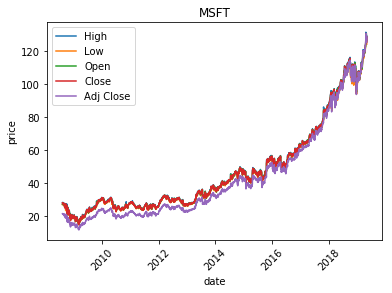

In [52]:
plot_stock(msft_df, title='MSFT')

C:\ProgramData\Anaconda3\envs\machine_learning_python\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


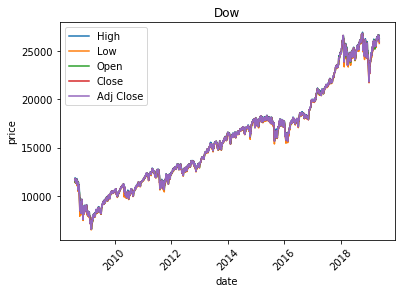

In [98]:
plot_stock(dji_df, title='Dow')

As an exercise in procrastination, we also filter the data some to remove some of the high frequency fluctuations using Fourier filtering. It should be noted that Fourier filtering assumes the data will repreat itself outside of the domain and therefore has no influene on predicting the future as it is. Rather, it only makes the curves smoother and potentially easier to understand.

In [53]:
import numpy as np

def Fourier_filter(data, filter_percent=0.9, plot=False, plot_title=''):
    f = np.fft.rfft(data) # use rfft because we have real inputs...
    f[int(len(data)*(1-filter_percent)):] = 0
    inv = np.fft.irfft(f)
    
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.plot(data, label='original')
        ax.plot(inv, label='filtered {}'.format(filter_percent))
        ax.legend()
        ax.set(title=plot_title, xlabel='time', ylabel='cost')
        fig.show()
    
    return inv

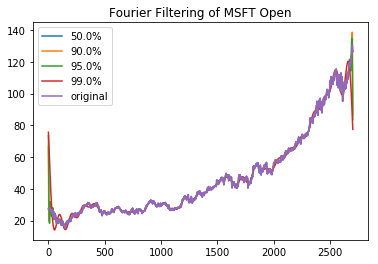

In [54]:
filterings = [0.5, 0.9, 0.95, 0.99]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for filt in filterings:
    res = Fourier_filter(msft_df['Open'].values, filter_percent=filt, plot=False)
    ax.plot(res, label='{}%'.format(filt*100))
ax.plot(msft_df['Open'].values, label='original')
l = ax.legend()
ax.set_title('Fourier Filtering of MSFT Open')
fig.show()

Now back to the real work, we need to preprocess the data some to be able to use it. First, let us make a new target of the change in the closing price from the previoius day. This is a somewhat well behaved parameter.

In [55]:
msft_df['Change'] = msft_df['Close'].diff()
msft_df['Change'] = msft_df['Change'].shift(-1)
msft_df.head()

,High,Low,Open,Close,Volume,Adj Close,Change
Date,,,,,,,
2008-08-08,28.230000,27.190001,27.350000,28.129999,80814100.0,21.626917,-0.230000
2008-08-11,28.400000,27.660000,27.860001,27.900000,68743800.0,21.450087,0.220001
2008-08-12,28.360001,27.580000,27.780001,28.120001,62813000.0,21.619234,-0.210001
2008-08-13,28.500000,27.760000,28.070000,27.910000,51165200.0,21.457777,0.000000
2008-08-14,28.280001,27.559999,27.820000,27.910000,49732300.0,21.457777,-0.100000


C:\ProgramData\Anaconda3\envs\machine_learning_python\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\envs\machine_learning_python\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([   2.,   11.,   21.,  106., 1719.,  766.,   55.,   14.,    6.,
           3.]),
 array([-6.09999847, -4.82999878, -3.55999908, -2.28999939, -1.01999969,
         0.25      ,  1.51999969,  2.78999939,  4.05999908,  5.32999878,
         6.59999847]),
 <a list of 10 Patch objects>)

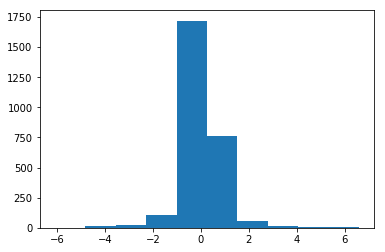

In [56]:
plt.hist(msft_df['Change'])

In [57]:
msft_df.dropna(inplace=True)
msft_df.isna().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
Change       0
dtype: int64

Although we expected no na values, it is a good idea to check. Now we can normalize the data. We will use `MinMaxScalar`, but we could also use `StandardScalar` and likely have similar results. Because we only want to fit the transformation on the training data, we will also do the train-test split (80-20 split). Since we want to preserve the time structure of the data, we will explicetly set `shuffle=False` when calling `train_test_split`.

In [58]:
from sklearn.preprocessing import MinMaxScaler

# how do you normalize these? How do you not data snoop?
Data_df = msft_df[[col for col in list(msft_df) if col != 'Change']]
Target_df = msft_df['Change']

# now the normalization
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(Data_df.values)
Y = Target_df.values

In [59]:
print(len(X), len(Y))
print(X.shape)
print(Data_df.iloc[1])

2703 2703
(2703, 6)
High         2.840000e+01
Low          2.766000e+01
Open         2.786000e+01
Close        2.790000e+01
Volume       6.874380e+07
Adj Close    2.145009e+01
Name: 2008-08-11 00:00:00, dtype: float64


In [60]:
# function for making the data sets
def make_datasets(X, Y, length=60):
    if len(X) != len(Y):
        print('you done messed up')
    X_data_list = []
    Y_data_list = []
    for i in range(length, len(X)):
        X_data_list.append(X[i-length:i,:])
        Y_data_list.append(Y[i])
            
    X_data = np.array(X_data_list)
    Y_data = np.array(Y_data_list)
    return(X_data, Y_data)

In [99]:
X_dataset, Y_dataset = make_datasets(X, X[:,3])

In [109]:
print('X_dataset shape {}'.format(X_dataset.shape))
print('Y_dataset shape {}'.format(Y_dataset.shape))
#print('1 {}'.format(X_dataset[1][:10,:]))
#print('2 {}'.format(X_dataset[2][:10,:]))
print(X_dataset[-1][:1,:])
print(X_dataset[-2][:1,:])

X_dataset shape (2643, 60, 6)
Y_dataset shape (2643,)
[[0.77727862 0.78082432 0.7802827  0.78059759 0.07161158 0.78291746]]
[[0.78946008 0.79165211 0.79597677 0.78718055 0.04227164 0.78929051]]


In [125]:
test_size=0.2
rand_ind = np.random.randint(0, high=X_dataset.shape[0], size=int(test_size*X_dataset.shape[0]))

X_train = []
X_test = []
Y_train = []
Y_test = []

for i in range(X_dataset.shape[0]):
    if i in rand_ind:
        X_test.append(X_dataset[i,:,:])
        Y_test.append(Y_dataset[i])
    else:
        X_train.append(X_dataset[i,:,:])
        Y_train.append(Y_dataset[i])
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

print('X test shape {}'.format(X_test.shape))
print('Y test shape {}'.format(Y_test.shape))
print('X train shape {}'.format(X_train.shape))
print('Y train shape {}'.format(Y_train.shape))

X test shape (476, 60, 6)
Y test shape (476,)
X train shape (2167, 60, 6)
Y train shape (2167,)


In [131]:
from keras.models import Input, Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

input_holder = Input(shape=(X_dataset.shape[1],X_dataset.shape[2]))

x = LSTM(10, dropout=0.2, activation='relu', recurrent_dropout=0.2)(input_holder)
x = Dense(10, activation='relu')(x)
x = Dense(5, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

simple_model = Model(inputs=input_holder, outputs=x)
simple_model.compile(loss='mse',
                     optimizer='adam')
print(simple_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 60, 6)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 10)                680       
_________________________________________________________________
dense_24 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 6         
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________
None


In [132]:
simple_model.fit(X_train, Y_train, batch_size=128, epochs=150, verbose=1, validation_data=(X_test, Y_test),
                 callbacks=[EarlyStopping(monitor='val_loss', 
                                          patience=3,
                                          restore_best_weights=True)])

Train on 2167 samples, validate on 476 samples
Epoch 1/150
2167/2167 [==============================] - 3s 2ms/step - loss: 0.0964 - val_loss: 0.0892
Epoch 2/150
2167/2167 [==============================] - 2s 806us/step - loss: 0.0815 - val_loss: 0.0745
Epoch 3/150
2167/2167 [==============================] - 2s 794us/step - loss: 0.0640 - val_loss: 0.0536
Epoch 4/150
2167/2167 [==============================] - 2s 817us/step - loss: 0.0450 - val_loss: 0.0416
Epoch 5/150
2167/2167 [==============================] - 2s 834us/step - loss: 0.0322 - val_loss: 0.0256
Epoch 6/150
2167/2167 [==============================] - 2s 818us/step - loss: 0.0230 - val_loss: 0.0175
Epoch 7/150
2167/2167 [==============================] - 2s 833us/step - loss: 0.0192 - val_loss: 0.0204
Epoch 8/150
2167/2167 [==============================] - 2s 841us/step - loss: 0.0155 - val_loss: 0.0138
Epoch 9/150
2167/2167 [==============================] - 2s 828us/step - loss: 0.0133 - val_loss: 0.0105
Epoch 10/1

In [133]:
y_hat = simple_model.predict(X_dataset)

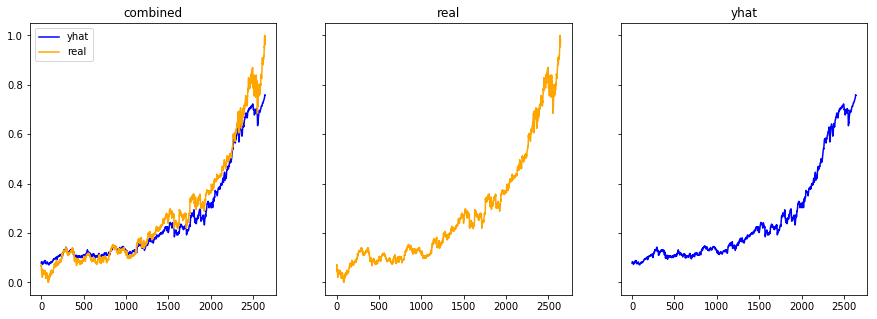

In [134]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,5))

ax[0].set_title('combined')
ax[0].plot(y_hat, label='yhat', color='blue')
ax[0].plot(Y_dataset, label='real', color='orange')
l = ax[0].legend()

ax[1].set_title('real')
ax[1].plot(Y_dataset, color='orange')

ax[2].set_title('yhat')
ax[2].plot(y_hat, color='blue')
plt.show()

(2643, 1)
(2643, 6)


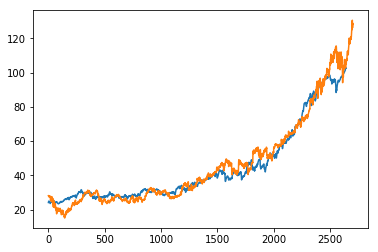

In [148]:
y_s = np.concatenate([y_hat, y_hat, y_hat, y_hat, y_hat, y_hat], axis=1)
print(y_hat.shape)
print(y_s.shape)
y_pred = min_max_scaler.inverse_transform(y_s)[:,3]
plt.plot(y_pred)
plt.plot(msft_df['Close'].values)

(array([   2.,    0.,   10.,   20.,   71.,  288.,  891., 1110.,  198.,
          53.]),
 array([0.02679411, 0.0273051 , 0.0278161 , 0.0283271 , 0.02883809,
        0.02934909, 0.02986008, 0.03037108, 0.03088208, 0.03139307,
        0.03190407], dtype=float32),
 <a list of 10 Patch objects>)

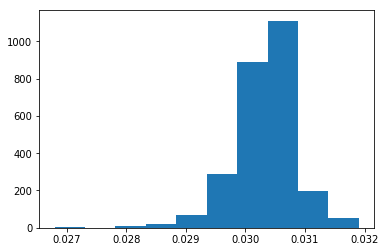

In [97]:
plt.hist(y_hat)

In [94]:
mlp_input = Input(shape=(X_dataset.shape[1]*X_dataset.shape[2]))
x = Dense(256, activation='relu')(mlp_input)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(x)
x = Dense(1, activation='sigmoid')

mlp = Model(inputs=mlp_input, outputs=x)
mlp.compile(loss='mse', optimizer='adam')
print(mlp.summary)

TypeError: 'int' object is not iterable

<a id="visualize_embeddings"></a>

## Visualize Word Embeddings

> One idea (__required for 7000 level students__): Use t-SNE (or SVD) to visualize the word embeddings of a subset of words in your vocabulary. Try to interpret what each dimension reflects (in your own words). That is, try to explain what aspect of the language is encoded in the reduced dimensionality embedding. 

For this section we will start with a embedding matrix of our vocabulary using GloVe 50, 100, 200, and 300. We will then use t-SNE to reduce the dimensionality to 2 dimensions. We will then find the lenght of the diffence vectors between two words that we think are similar. Finally we will compare the diffence vectors length from each of the starting dimensionalities and see how close the words remained in reduced dimensionality space.

In [435]:
# first loat the constitution and clean it some
with open('texts/const.txt', 'r') as f:
    dat = f.read().lower()
    
word = ''
word_list = []
for c in dat:
    if c in ['\n']:
        c = ' '
    if c in [',', '.', ';']:
        continue
    if c == ' ': # new word
        if word != '':
            word_list.append(word)
        word = ''
    else:
        word += c
        
print('first 5 words: {}'.format(word_list[:5]))
print('total words found {}'.format(len(word_list)))

first 5 words: ['we', 'the', 'people', 'of', 'the']
total words found 7620


In [436]:
# now tokenize to get the dictionary
import keras
from keras.preprocessing.text import Tokenizer

NUM_TOP_WORDS=None

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(word_list)
sequences = tokenizer.texts_to_sequences(word_list)

word_index = tokenizer.word_index

In [437]:
embed_sizes = [50, 100, 200, 300]
full_size_embed_dict = {}
for EMBED_SIZE in embed_sizes:
    print('working on size {}'.format(EMBED_SIZE))
    # the embed size should match the file you load glove from
    embeddings_index = {}
    with open('glove.6B/glove.6B.{}d.txt'.format(EMBED_SIZE), 'r', encoding='utf-8') as f:
    # save key/array pairs of the embeddings
    #  the key of the dictionary is the word, the array is the embedding
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))

    # now fill in the matrix, using the ordering from the
    #  keras word tokenizer from before
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    print('embedding matrix size {}'.format(embedding_matrix.shape))
    full_size_embed_dict[EMBED_SIZE] = embedding_matrix

working on size 50
Found 400000 word vectors.
embedding matrix size (1167, 50)
working on size 100
Found 400000 word vectors.
embedding matrix size (1167, 100)
working on size 200
Found 400000 word vectors.
embedding matrix size (1167, 200)
working on size 300
Found 400000 word vectors.
embedding matrix size (1167, 300)


In [ ]:
# now use t-SNE to reduct dimensionality for each starting dimension
reduced_size_embed_dict = {}
embed_sizes = [50]

<a id="novel_text"></a>

## Novel Text

> Another Idea (NOT required): Try to create a RNN for generating novel text. 

### Word by Word

In [328]:
# first get a list of words

with open('texts/const.txt', 'r') as f:
    dat = f.read().lower()
    
i = 0
word = ''
word_list = []
for c in dat:
    if c in ['\n']:
        c = ' '
    if c in [',', '.', ';']:
        continue
    if c == ' ': # new word
        if word != '':
            word_list.append(word)
        word = ''
    else:
        word += c
        
print(word_list[:5])

['we', 'the', 'people', 'of', 'the']


In [330]:
const_words = sorted(list(set(word_list))) # get unique words
print('unique words {}'.format(len(const_words)))
print('total words {}'.format(len(word_list)))

unique words 1185
total words 7620


In [331]:
word_indices = dict((c,i) for i, c in enumerate(const_words))
indices_word = dict((i,c) for i, c in enumerate(const_words))

In [335]:
print(word_indices['we'])
print(indices_word[1147])

1147
we


In [375]:
max_len = 40
step = 3
sentences = []
next_words = []
for i in range(0, len(word_list) - max_len, step):
    sentences.append(word_list[i:i+max_len])
    next_words.append(word_list[i+max_len])
    
x = np.zeros((len(sentences), max_len, len(const_words)), dtype=np.bool)
y = np.zeros((len(sentences), len(const_words)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, word in enumerate(sentence):
        x[i, t, word_indices[word]] = 1
    y[i, word_indices[next_words[i]]] = 1

In [376]:
%%time
EMBED_SIZE = 50
# the embed size should match the file you load glove from
embeddings_index = {}
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
with open('glove.6B/glove.6B.50d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
embedding_matrix = np.zeros((len(word_indices) + 1, EMBED_SIZE))
for word, i in word_indices.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Found 400000 word vectors.
(1186, 50)
Wall time: 9.38 s


In [377]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_indices)+1,
                           EMBED_SIZE,
                           weights=[embedding_matrix],
                           input_length=max_len,
                           trainable=False)

In [381]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
    
word_model = Sequential()
word_model.add(embedding_layer)
word_model.add(LSTM(128, input_shape=(max_len, len(const_words))))
word_model.add(Dense(len(const_words)))
word_model.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
word_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
print(word_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 50)            59300     
_________________________________________________________________
lstm_23 (LSTM)               (None, 128)               91648     
_________________________________________________________________
dense_38 (Dense)             (None, 1185)              152865    
_________________________________________________________________
activation_11 (Activation)   (None, 1185)              0         
Total params: 303,813
Trainable params: 244,513
Non-trainable params: 59,300
_________________________________________________________________
None


In [370]:
# helper functions from official LSTM text generation example from Keras Team
from keras.callbacks import LambdaCallback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger
import random
import sys

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    print('----- Generating text after Epoch: %d' % epoch, file=writefile)
    
    start_index = 0
    #start_index = random.randint(0, len(const) - max_len - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)
        print('----- diversity:', diversity, file=writefile)

        generated = []
        #sentence = const[start_index: start_index + max_len]
        sentence = ['amendment']
        generated += sentence
        print('----- Generating with seed: "{}"'.format(sentence))
        print('----- Generating with seed: "{}"'.format(sentence), file=writefile)
        sys.stdout.write(' '.join(generated))
        print(generated, file=writefile)

        for i in range(40):
            x_pred = np.zeros((1, max_len, len(const_words)))
            for t, word in enumerate(sentence):
                x_pred[0, t, word_indices[word]] = 1.

            preds = word_model.predict(x_pred, verbose=0)[0]
            next_word = sample(preds, diversity)
            next_word = indices_word[next_word]

            generated += next_word
            sentence = sentence[1:] + [next_word]

            sys.stdout.write(next_word+' ')
            print(next_word,file=writefile, end=' ')
            sys.stdout.flush()
        print()
        print(file=writefile)
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

chkpt_filepath = 'model_checkpoints/weights_words.hdf5'
checkpoint = ModelCheckpoint(chkpt_filepath, monitor='loss',
                             verbose=1, save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.001)
#csv_logger = CSVLogger('texts/const_pred.log')
callbacks = [print_callback, checkpoint, reduce_lr]

In [382]:
word_model.fit(x, y, batch_size=128, epochs=10, callbacks=[reduce_lr])
writefile=open('texts/const_words_out.txt','a+')
word_model.fit(x, y, batch_size=128, epochs=2, callbacks=[print_callback])
writefile.close()

ValueError: Error when checking input: expected embedding_2_input to have 2 dimensions, but got array with shape (2527, 40, 1185)

### Character by Character

In [318]:
with open('texts/const.txt', 'r') as f:
    const = f.read().lower()
print('const len {}'.format(len(const)))

const len 44841


In [319]:
chars = sorted(list(set(const))) # get unique characters
print('total chars {}'.format(len(chars)))

total chars 46


In [320]:
char_indices = dict((c,i) for i, c in enumerate(chars))
indices_char = dict((i,c) for i, c in enumerate(chars))

In [321]:
max_len = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(const) - max_len, step):
    sentences.append(const[i:i+max_len])
    next_chars.append(const[i+max_len])
    
x = np.zeros((len(sentences), max_len, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [322]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
    
model = Sequential()
model.add(LSTM(128, input_shape=(max_len, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 128)               89600     
_________________________________________________________________
dense_32 (Dense)             (None, 46)                5934      
_________________________________________________________________
activation_5 (Activation)    (None, 46)                0         
Total params: 95,534
Trainable params: 95,534
Non-trainable params: 0
_________________________________________________________________
None


In [323]:
# helper functions from official LSTM text generation example from Keras Team
from keras.callbacks import LambdaCallback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger
import random
import sys

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

writefile=open('texts/const_out.txt','a+')
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    print('----- Generating text after Epoch: %d' % epoch, file=writefile)
    
    start_index = 0
    #start_index = random.randint(0, len(const) - max_len - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)
        print('----- diversity:', diversity, file=writefile)

        generated = ''
        #sentence = const[start_index: start_index + max_len]
        sentence = 'amendment 28'
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        print('----- Generating with seed: "' + sentence + '"', file=writefile)
        sys.stdout.write(generated)
        print(generated, file=writefile)

        for i in range(400):
            x_pred = np.zeros((1, max_len, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            print(next_char,file=writefile, end='')
            sys.stdout.flush()
        print()
        print(file=writefile)
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

chkpt_filepath = 'model_checkpoints/weights.hdf5'
checkpoint = ModelCheckpoint(chkpt_filepath, monitor='loss',
                             verbose=1, save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.001)
#csv_logger = CSVLogger('texts/const_pred.log')
callbacks = [print_callback, checkpoint, reduce_lr]

In [324]:
model.fit(x, y, batch_size=128, epochs=2, callbacks=callbacks)
writefile.close()

Epoch 1/2
14934/14934 [==============================] - 11s 704us/step - loss: 2.5570

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "amendment 28"
amendment 28eoeeioetioieoeoee etiiooe eeioo ooeei et eee o eee eies ioeti   eieeteeoo see ieoee  oeeeoe t eie tee t  oei te eoo ietoieei ei oot eo eoe e eoee ioeio o oeeooeesi see iteoee eeieoieoeeeee  eoe iteoeeeeoeeee oeio eoe  eooeoiroe e oeeeeoeoeio eeeio ee eeeieeoieeoeee eeteo  eeeee  oeeoteoeie eoeeoioeoeie e o ei ee s eo  eeeeeieae t  eeeeoeioeoeoe eeioateeoo  eooeeeeoiteeoeo  eeeoeeoeee eeieieoeeeoee
----- diversity: 0.5
----- Generating with seed: "amendment 28"
amendment 28 tlio otcee etoioee nii-tsee oeaetsoen  aeoieacigti  rtetoobei e taoaoie  iatoeesan mtiaeototes seso co titooestote otetoees reog it oo oi taeittosts soi  eiie oe  to co oldgoio  esteee a tt,oosetev  tosetseoeoa s niootneeete c oeteepei oe n  eo oteeoe  s  neeeteottetiott  eitti eioveiamoeeene nieeis ereoemeooeei ioas  i

KeyboardInterrupt: 

In [205]:
writefile.close()